<a href="https://colab.research.google.com/github/LM1997610/TimeSeries-KPMG/blob/main/KPMG_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## <h1><center> **Sapienza Training Camp** </center></h1>
## <h2><center> Time Series Forecasting with *KPMG* </center></h2>
## <h4><center> July 2024 </center></h4>

Group name: &ensp; **`Ki Programma Male Group`**

Team members:

- Lucia Dicunta: 2037075
- Ioan Corrias: 2079420
- Luca Mazzucco: 1997610
- Cosmin Madalin Zaharia: 1805207

In [ ]:
! pip -q install opendatasets

In [2]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import opendatasets as od
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from google.colab import files
from collections import Counter
from IPython.display import Image

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose


from sklearn.metrics import mean_absolute_percentage_error

In [3]:
! git clone https://github.com/LM1997610/TimeSeries-KPMG

Cloning into 'TimeSeries-KPMG'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 43 (delta 22), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (43/43), 16.16 KiB | 4.04 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [4]:
os.chdir('TimeSeries-KPMG')

from functions import *

from scoring_metric import solution_to_global
from scoring_metric import mape_score as mape_score_function

In [5]:
data_url = 'https://www.kaggle.com/competitions/sapienza-training-camp-forecasting-2024'

od.download(data_url) # 9638d6a35ee6e3a36aa4c061ec86df6b

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lmazzucco
Your Kaggle Key: ··········


100%|██████████| 75.4k/75.4k [00:00<00:00, 49.9MB/s]


Extracting archive ./sapienza-training-camp-forecasting-2024/sapienza-training-camp-forecasting-2024.zip to ./sapienza-training-camp-forecasting-2024


In [6]:
data = pd.read_csv('sapienza-training-camp-forecasting-2024/train.csv')

print(f'data.shape: {data.shape}')

data.shape: (5793, 9)


In [7]:
display(data.head())

,volume_kg,distribution_channel,customer,brand,channel,store_format,category,year,month
0,460.026585,0,1,1,FOOD SERVICE,3,3,2010,1
1,456.944328,0,1,1,FOOD SERVICE,3,3,2010,2
2,926.790243,0,1,1,FOOD SERVICE,3,3,2010,3
3,762.549167,0,1,1,FOOD SERVICE,3,3,2010,4
4,1132.060704,0,1,1,FOOD SERVICE,3,3,2010,5


In [8]:
data['date'] = pd.to_datetime(data[['year', 'month']].assign(day=1))

In [9]:
data['custom_id'] = data.apply(lambda row:
      f"{row['distribution_channel']}_{row['customer']}_{row['brand']}_{row['channel']}_{row['store_format']}_{row['category']}", axis=1)

cols_to_drop = ['distribution_channel', 'customer', 'brand', 'channel',
                        'store_format',  'category', 'year', 'month']

data = data.drop(columns=cols_to_drop)

In [10]:
display(data.head())

,volume_kg,date,custom_id
0,460.026585,2010-01-01,0_1_1_FOOD SERVICE_3_3
1,456.944328,2010-02-01,0_1_1_FOOD SERVICE_3_3
2,926.790243,2010-03-01,0_1_1_FOOD SERVICE_3_3
3,762.549167,2010-04-01,0_1_1_FOOD SERVICE_3_3
4,1132.060704,2010-05-01,0_1_1_FOOD SERVICE_3_3


In [11]:
def get_series(data, serie_index):

  serie_names = data['custom_id'].unique()

  if serie_index >= len(serie_names):
    raise IndexError('Index out of range')

  this_name = serie_names[serie_index]
  this_serie = data[data['custom_id'] == this_name].reset_index(drop=True)
  this_serie = this_serie.set_index('date')

  return this_serie

In [12]:
serie_names = data['custom_id'].unique()

print(f'Number of Series: {len(serie_names)}')

Number of Series: 48


In [13]:
all_series = [get_series(data, serie_index=i) for i in range(len(serie_names))]

In [14]:
def count_data_points_and_missing_dates(group):

    group = group.asfreq('MS')
    count = group['volume_kg'].count()
    missing_dates = group['volume_kg'].isna().sum()

    return count, missing_dates

In [15]:
count =  dict(Counter([count_data_points_and_missing_dates(serie) for serie in all_series]).items())

for k, c in count.items():
  print(f'{c:>2} TimeSeries of lenght {k[0]:>3} -> {k[1]:>2} missing values')

 2 TimeSeries of lenght 121 ->  3 missing values
36 TimeSeries of lenght 124 ->  0 missing values
 5 TimeSeries of lenght 123 ->  1 missing values
 1 TimeSeries of lenght 119 ->  5 missing values
 1 TimeSeries of lenght 120 ->  4 missing values
 2 TimeSeries of lenght  65 ->  0 missing values
 1 TimeSeries of lenght 103 -> 21 missing values


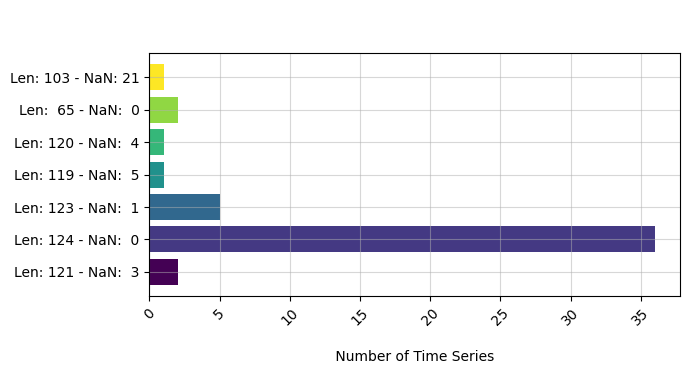

In [16]:
n_bars = range(len(count.keys()))

colors = plt.cm.viridis(np.linspace(0, 1, len(n_bars)))
labels = [f'Len: {x[0]:>3} - NaN: {x[1]:>2}' for x in count.keys()]

plt.figure(figsize=(7, 4))
plt.barh(n_bars, count.values(), tick_label=labels, color=colors)

plt.title('\n')
plt.xlabel('\n Number of Time Series \n')

plt.xticks(rotation=45)
plt.tight_layout()
plt.grid('--', alpha=0.5)

plt.show()

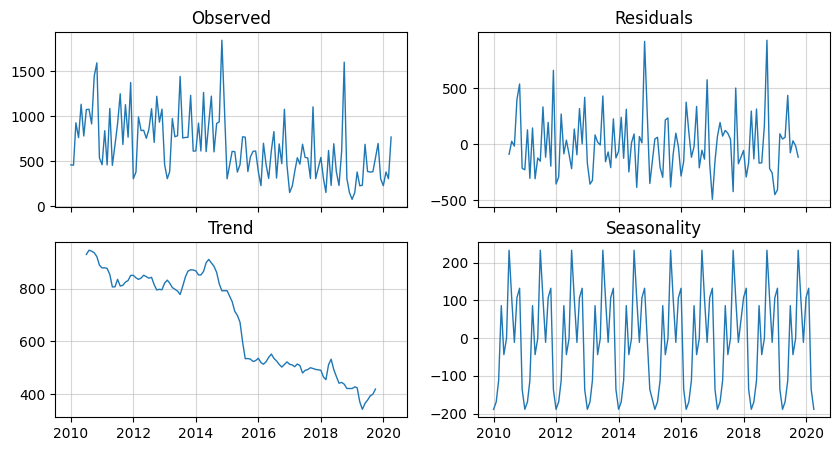

In [17]:
decomposition = seasonal_decompose(all_series[0].drop(columns=["custom_id"]), model='additive', period=12)

components = [('Observed', decomposition.observed), ('Residuals', decomposition.resid),
              (   'Trend', decomposition.trend),    ('Seasonality', decomposition.seasonal)]

fig, ax = plt.subplots(2, 2, figsize=(10, 5), sharex=True)

for idx, (comp_title, comp_data) in enumerate(components):
  row, col = divmod(idx, 2)
  ax[row][col].plot(comp_data, linewidth=1)
  ax[row][col].set_title(comp_title)
  ax[row][col].grid('-', alpha=0.5)

plt.show()


In [19]:
## Testing for Stationarity:

stationarity = []
non_stationarity = []

for indx in range(len(serie_names)):

  this_serie_name = serie_names[indx]
  this_serie = get_series(data, serie_index=indx)

  adfuller_test = adfuller(this_serie['volume_kg'])

  if adfuller_test[1] < 0.05: stationarity.append((this_serie_name, indx))   ## p-value
  else: non_stationarity.append((this_serie_name, indx))

print(f'{"":>5}Stationary Time Series: {len(stationarity)}')
print(f' Non-Stationary Time Series: {len(non_stationarity)}')

     Stationary Time Series: 14
 Non-Stationary Time Series: 34


-------------------------------------------------------------

## ARIMA:

In [20]:
def split_train_test(la_mia_serie, date_of_division = '2020-04-01'):

  train = la_mia_serie.loc[la_mia_serie.index < date_of_division].copy()
  test = la_mia_serie.loc[la_mia_serie.index >= date_of_division].copy()

  return train, test

In [21]:
test_start_dt = '2019-01-01'
indx = 0

this_serie_name = serie_names[indx]
this_serie = get_series(data, serie_index=indx)

train, test = split_train_test(this_serie, date_of_division = test_start_dt)

print(f'>> train.shape: {train.shape}')
print(f'>> test.shape: {str(test.shape):>8}')

>> train.shape: (105, 2)
>> test.shape:  (16, 2)


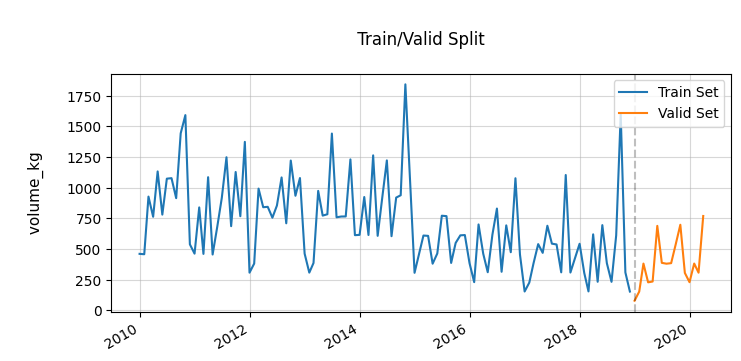

In [22]:
fig, ax = plt.subplots(figsize=(8, 3.5))

train.plot(ax=ax, label='Training Set', title='\n Train/Valid Split \n')
test.plot(ax=ax, label='Test Set')

ax.axvline(test_start_dt, color='black', ls='--', alpha=0.25)

plt.ylabel('\n volume_kg \n', fontsize=11)
plt.legend(['Train Set', 'Valid Set'], loc='upper right')
plt.grid('-', alpha=0.5)

plt.xlabel('')
plt.show()

In [23]:
mape_score_list = []           ## order = (5, 1, 0)
valid_df = []
kaggle_results = []

test_start_dt = '2019-01-01'

for indx in tqdm(range(len(serie_names))):

    this_serie_name = serie_names[indx]
    this_serie = get_series(data, serie_index=indx)
    this_serie = this_serie

    train, test = split_train_test(this_serie, date_of_division=test_start_dt)

    ###############################################################
    model = ARIMA(train['volume_kg'].asfreq('MS'), order=(5, 1, 0))
    model_fit = model.fit()
#   #######################

    train['predictions'] = model_fit.predict(start=train.index.min(), end=test_start_dt)
    test['predictions'] = model_fit.predict(start=test_start_dt, end=test.index[-1])
#
    mape = mean_absolute_percentage_error(test['volume_kg'], test['predictions'])
    mape_score_list.append(mape)
    valid_df.append(test)

    ## prediction for Kaggle:

    k_pred = model_fit.predict(start='2020-05-01', end='2020-08-01')

    k_data = pd.DataFrame(k_pred)
    k_data['custom_id'] = [this_serie_name]*len(k_data)
    kaggle_results.append(k_data)

kaggle_df = pd.concat(kaggle_results)
valid_df = pd.concat(valid_df)

  0%|          | 0/48 [00:00<?, ?it/s]

In [24]:
kaggle_sub = kaggle_df.copy()

kaggle_sub['id'] = kaggle_df.index.year.astype(str)+ '_' +kaggle_df.index.month.astype(str)+ '_' + kaggle_df['custom_id']

volumes = kaggle_sub['predicted_mean']

kaggle_sub = kaggle_sub.drop(columns=['custom_id', 'predicted_mean'])
kaggle_sub['volume_kg'] = volumes
kaggle_sub = kaggle_sub.reset_index(drop=True)


filename = 'submission_ARIMA.csv'

if not os.path.exists('submissions/'):
  os.makedirs('submissions/')

kaggle_sub.to_csv('submissions/'+filename, index=False)
print(f'>> Saved {filename} - shape: {kaggle_sub.shape} - {list(kaggle_sub.columns)}')

>> Saved submission_ARIMA.csv - shape: (192, 2) - ['id', 'volume_kg']


In [25]:
## Metrics on Validation Set:

valid_df['id'] = valid_df.index.year.astype(str)+ '_' +valid_df.index.month.astype(str)+ '_' + valid_df['custom_id']

volumes = valid_df['volume_kg']
predictions = valid_df['predictions']
cols_to_drop = ['custom_id', 'predictions', 'volume_kg']

my_val_pred = valid_df.drop(columns=cols_to_drop)
valid_label = valid_df.drop(columns=cols_to_drop)

my_val_pred['volume_kg'] = predictions
valid_label['volume_kg'] = volumes

my_val_pred = my_val_pred.reset_index(drop=True)
valid_label = valid_label.reset_index(drop=True)

In [26]:
kaggle_score = mape_score_function(solution = valid_label,
                                   submission = my_val_pred,
                                   row_id_column_name = 'id')

avg_mape = np.mean(mape_score_list)

print(f' >> kaggle_score: {kaggle_score:>.3f} | mape: {avg_mape:>.3f}')

global_solution = solution_to_global(valid_label, row_id_column_name='id')
global_submission = solution_to_global( my_val_pred, row_id_column_name='id')

global_mape = mean_absolute_percentage_error(global_solution.to_numpy(),
                                             global_submission.to_numpy())

mape = mean_absolute_percentage_error(valid_label["volume_kg"].to_numpy(),
                                      my_val_pred["volume_kg"].to_numpy())

test_score = (3 * mape + global_mape) / 4

print(f' >> kaggle_score: {test_score:>.3f} | mape: {mape:>.3f} | global_mape: {global_mape:>.3f}')

 >> kaggle_score: 0.584 | mape: 0.743
 >> kaggle_score: 0.584 | mape: 0.741 | global_mape: 0.112


-------------------------------------------

## Prophet

## <h2><center>XGBoost</center></h2>

In [28]:
import xgboost as xgb

In [73]:
one_serie = get_series(data, serie_index=0)

d_day = '2018-09-01'

train, valid = split_train_test(one_serie, date_of_division = d_day)

print(f'Serie.shape: {one_serie.shape} \n')

print(f'>> Train: {train.shape}')
print(f'>> Valid: {valid.shape}')

Serie.shape: (121, 2) 

>> Train: (101, 2)
>> Valid: (20, 2)


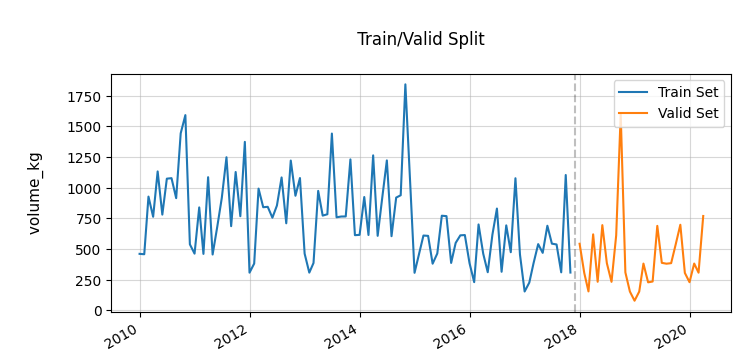

In [64]:
fig, ax = plt.subplots(figsize=(8, 3.5))

train.plot(ax=ax, label='Training Set', title='\n Train/Valid Split \n')
valid.plot(ax=ax, label='Test Set')

ax.axvline(d_day, color='black', ls='--', alpha=0.25)

plt.ylabel('\n volume_kg \n', fontsize=11)
plt.legend(['Train Set', 'Valid Set'], loc='upper right')
plt.grid('-', alpha=0.5)

plt.xlabel('')
plt.show()

In [65]:
# detect and remove outliers with StatsModels.Seasonal_decompose

def remove_outliers_seasonal(dataframe: pd.DataFrame, model='additive', sigma=3, fill=False):

    decomposition = seasonal_decompose(dataframe['volume_kg'], model=model, period=12)

    residual = decomposition.resid
    mean_resid = residual.mean()
    std_resid = residual.std()

    outliers = (residual - mean_resid).abs() > (sigma * std_resid)    # detect outliers
    df_no_outliers = dataframe[~outliers]                             # remove outliers

    # fill outliers with trend + seasonality:
    if fill ==True:

      trend_seasonal = decomposition.trend + decomposition.seasonal
      dataframe['volume_kg'] = np.where(outliers, trend_seasonal, dataframe['volume_kg'])
      return dataframe

    return df_no_outliers

In [66]:
grouped = data.groupby('custom_id')

df_no_outliers = grouped.apply(remove_outliers_seasonal, fill=False).reset_index(drop=True)

print(f'    Original data: {data.shape}')
print(f' Without Outliers: {df_no_outliers.shape}')

filled_df = grouped.apply(remove_outliers_seasonal, fill=True).reset_index(drop=True)

    Original data: (5793, 3)
 Without Outliers: (5732, 3)


In [67]:
def compute_features(df):

    df = df.copy()
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['quarter'] = df.index.quarter
    df['semester'] = np.where(df['quarter'] > 2,2,1)
    df['month'] = df.index.month

    #df['lag_1'] = df['volume_kg'].shift(1)
    #df['lag_2'] = df['volume_kg'].shift(2)

    return df

In [79]:
d_day = '2017-09-01'

mape_scores_list = []
kaggle_prediction = []

valid_prediction_list = []
validation_gtrue_list = []

serie_names = data['custom_id'].unique()

features = ['year', 'dayofyear', 'quarter', 'semester', 'month']
target = 'volume_kg'

for indx in tqdm(range(len(serie_names))):

  this_serie_name = serie_names[indx]
  this_serie = get_series(df_no_outliers, serie_index=indx)

  this_serie = compute_features(this_serie)

  #split_index = int(len(this_serie) * (1 - test_size))
  #d_day = this_serie.index[split_index]

  train, test = split_train_test(this_serie, date_of_division = d_day)

  X_train = train[features]
  y_train = train[target]

  X_valid = test[features]
  y_valid= test[target]

  reg = xgb.XGBRegressor(base_score=0.5,
                        booster='gbtree',
                        n_estimators=1000,
                        early_stopping_rounds=50,
                        objective='reg:squarederror',
                        max_depth=3,
                        learning_rate=0.01)

  _ = reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=0)

  valid_predictions = reg.predict(X_valid)
  vscore = mean_absolute_percentage_error(y_valid, valid_predictions)
  mape_scores_list.append(vscore)

  for i, val_pred in enumerate(valid_predictions):
    valid_prediction_list.append({'custom_id': this_serie_name,
                                       'year': test.index[i].year,
                                      'month': test.index[i].month,
                                  'volume_kg': val_pred})

  for i, ground_true in enumerate(y_valid):
        validation_gtrue_list.append({'custom_id': this_serie_name,
                                           'year': test.index[i].year,
                                          'month': test.index[i].month,
                                      'volume_kg': ground_true})

  test_set = build_test_set(this_serie, compute_features)
  predictions = reg.predict(test_set)
#
  for i, pred in enumerate(predictions):
    kaggle_prediction.append({'custom_id': this_serie_name,
                                   'year': 2020,
                                  'month': i + 5,
                              'volume_kg': pred})

  0%|          | 0/48 [00:00<?, ?it/s]

In [80]:
kaggle_prediction = parse_and_save_results(kaggle_prediction, 'submission_XGBoost', save=True)

validation_gtrue = parse_and_save_results(validation_gtrue_list, '', save=False)
valid_prediction = parse_and_save_results(valid_prediction_list, '', save=False)

>> Saved submission_XGBoost.csv - shape: (192, 2) - ['id', 'volume_kg']


In [81]:
## Metrics on Validation Set:

kaggle_score = mape_score_function(solution = validation_gtrue,
                                   submission = valid_prediction,
                                   row_id_column_name = 'id')

avg_mape = np.mean(mape_scores_list)

print(f' >> kaggle_score: {kaggle_score:>.3f} | mape: {avg_mape:>.3f}')

global_solution = solution_to_global(validation_gtrue, row_id_column_name='id')
global_submission = solution_to_global(valid_prediction, row_id_column_name='id')

global_mape = mean_absolute_percentage_error(global_solution.to_numpy(),
                                             global_submission.to_numpy())

mape = mean_absolute_percentage_error(validation_gtrue["volume_kg"].to_numpy(),
                                      valid_prediction["volume_kg"].to_numpy())

test_score = (3 * mape + global_mape) / 4

print(f' >> kaggle_score: {test_score:>.3f} | mape: {mape:>.3f} | global_mape: {global_mape:>.3f}')

# >> kaggle_score: 0.316 | mape: 0.400 | global_mape: 0.064

 >> kaggle_score: 0.303 | mape: 0.383
 >> kaggle_score: 0.303 | mape: 0.382 | global_mape: 0.067


In [37]:
# >> kaggle_score: 0.303 | mape: 0.382 | global_mape: 0.067 >> d_day = 2017-09-01 >> Remove outliers
# >> kaggle_score: 0.311 | mape: 0.392 | global_mape: 0.068 >> d_day = 2017-09-01 >> Fill outliers
# >> kaggle_score: 0.312 | mape: 0.396 | global_mape: 0.062 >> d_day = 2018-04-01 >> Remove outliers
# >> kaggle_score: 0.319 | mape: 0.404 | global_mape: 0.064 >> d_day = 2018-04-01 >> Fill outliers
# >> kaggle_score: 0.338 | mape: 0.429 | global_mape: 0.066 >> d_day = 2018-04-01 >> Fill outliers >> Lag_1
# >> kaggle_score: 0.354 | mape: 0.448 | global_mape: 0.069 >> d_day = 2019-04-01 >> Fill outliers
# >> kaggle_score: 0.360 | mape: 0.457 | global_mape: 0.070 >> d_day = 2019-04-01 >> Remove outliers
# >> kaggle_score: 0.368 | mape: 0.467 | global_mape: 0.071 >> d_day = 2019-04-01 >> Fill outliers >> Lag_2
# >> kaggle_score: 0.371 | mape: 0.467 | global_mape: 0.081 >> d_day = 2019-04-01 >> Fill outliers >> Lag_1
# >> kaggle_score: 0.370 | mape: 0.470 | global_mape: 0.070 >> d_day = 2019-04-01

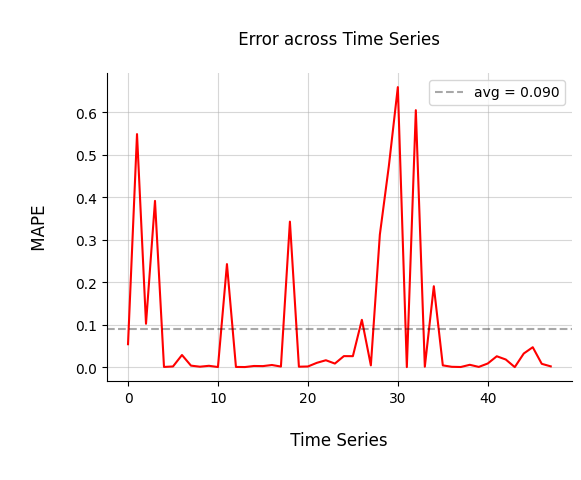

In [49]:
plt.figure(figsize=(6, 4))

plt.plot(mape_scores_list, color = 'r')

plt.axhline(np.mean(mape_scores_list), color='black', ls='--', alpha=0.34,label=f'avg = {np.mean(mape_scores_list):.3f}')

#highlight_indices  = {tupla[1]: mape_scores_list[tupla[1]] for tupla in non_stationarity}
#
#for index in highlight_indices:
#    plt.scatter(index, highlight_indices[index], color='green')


plt.title("\n Error across Time Series \n", fontsize=12)
plt.xlabel('\n Time Series \n', fontsize=12)
plt.ylabel('\n MAPE \n', fontsize=12)
plt.legend()
plt.grid('-', alpha=0.5)

plt.gca().spines[['top', 'right',]].set_visible(False)

plt.show()

In [39]:
def get_prediction(valid_prediction, this_serie_name):

  this_valid_pred = valid_prediction[valid_prediction['id'].str.contains(this_serie_name)]
  this_valid_pred.loc[:, ['year']] = this_valid_pred['id'].str.split('_', expand=True)[[0, 1]][0]
  this_valid_pred.loc[:, ['month']] = this_valid_pred['id'].str.split('_', expand=True)[[0, 1]][1]

  this_valid_pred.loc[:,['date']] = pd.to_datetime(this_valid_pred[['year', 'month']].assign(day=1))

  this_valid_pred = this_valid_pred.set_index('date')

  return this_valid_pred

In [40]:
serie_names = data['custom_id'].unique()

for indx in tqdm(range(len(serie_names))):

  this_serie_name = serie_names[indx]
  this_serie = get_series(df_no_outliers, serie_index=indx)

  this_valid_pred  = get_prediction(valid_prediction, this_serie_name)

  prediction_plot(this_serie, this_valid_pred, this_serie_name, output_dir = 'plots')


  0%|          | 0/48 [00:00<?, ?it/s]

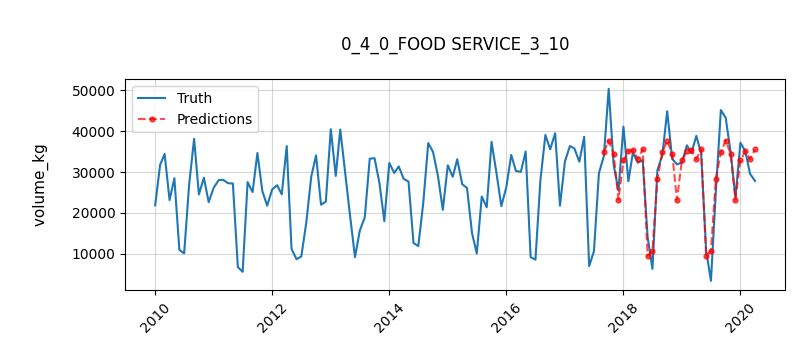

In [41]:
Image(filename=f'plots/{serie_names[4]}.png')

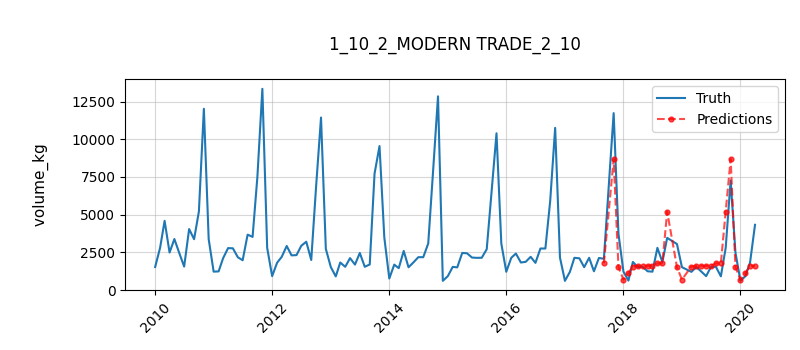

In [42]:
Image(filename=f'plots/{serie_names[30]}.png')

In [43]:
! zip -r  -q /content/TimeSeries_plots.zip  plots/

files.download('/content/TimeSeries_plots.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>